# Inventory Optimization (Scenario-Based Policy Evaluation)

This notebook builds on Project 1 (Inventory Analysis) by evaluating alternative inventory policies and quantifying the trade-off between service level and inventory investment.

Optimization Approach:
- Define a baseline policy (current setup from Project 1)
- Run policy scenarios (cover_days variants)
- Compare KPIs (fill rate, stockouts, lost sales value, average inventory value)
- Recommend improved replenishment parameters per SKU category
  

# 1. Load baseline dataset from Project 1

In [1]:
import pandas as pd

df = pd.read_csv("../data/inventory_data_2025.csv")

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"])

# Ensure value-based columns exist (if baseline file doesn't include them)
if "lost_sales_value" not in df.columns:
    df["lost_sales_value"] = df["lost_sales"] * df["unit_cost"]

if "inventory_value" not in df.columns:
    df["inventory_value"] = df["inventory_level"] * df["unit_cost"]


df.head()


,date,sku,category,supplier,unit_cost,moq,order_cost,holding_cost_rate_annual,lead_time_days,demand,...,stockout,receipts,order_qty,inventory_level,on_order,inventory_position,rop,order_up_to,lost_sales_value,inventory_value
0,2025-01-01,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,4,49,...,0,0,0,701,0,701,200.0,550.0,0.0,17525.0
1,2025-01-02,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,3,59,...,0,0,0,642,0,642,200.0,550.0,0.0,16050.0
2,2025-01-03,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,46,...,0,0,0,596,0,596,200.0,550.0,0.0,14900.0
3,2025-01-04,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,58,...,0,0,0,538,0,538,200.0,550.0,0.0,13450.0
4,2025-01-05,SKU_A,Fast Movers,supplier_1,25.0,75,45.0,0.22,6,50,...,0,0,0,488,0,488,200.0,550.0,0.0,12200.0


## 2. Baseline Performance (Benchmark)

Summarize baseline KPIs from Project 1 to serve as a benchmark for scenario evaluation.


In [2]:
baseline_kpi = df.groupby(["sku", "category"]).agg(
    days=("date", "nunique"),
    total_demand=("demand", "sum"),
    filled_demand=("filled_demand", "sum"),
    lost_sales_units=("lost_sales", "sum"),
    lost_sales_value=("lost_sales_value", "sum"),
    stockout_days=("stockout", "sum"),
    avg_inventory=("inventory_level", "mean"),
    avg_inventory_value=("inventory_value", "mean"),
).reset_index()

baseline_kpi["fill_rate"] = baseline_kpi["filled_demand"] / baseline_kpi["total_demand"]
baseline_kpi["stockout_rate"] = baseline_kpi["stockout_days"] / baseline_kpi["days"]

baseline_kpi = baseline_kpi.sort_values("lost_sales_value", ascending=False)
baseline_kpi


,sku,category,days,total_demand,filled_demand,lost_sales_units,lost_sales_value,stockout_days,avg_inventory,avg_inventory_value,fill_rate,stockout_rate
2,SKU_C,Slow Movers,365,5590,5084,506,63250.0,35,74.816438,9352.054795,0.909481,0.095890
1,SKU_B,Medium Movers,365,10957,10161,796,59700.0,32,125.273973,9395.547945,0.927352,0.087671
0,SKU_A,Fast Movers,365,18379,17413,966,24150.0,26,207.931507,5198.287671,0.947440,0.071233


### 2.1 Round values for readability


In [3]:
baseline_kpi["fill_rate"] = baseline_kpi["fill_rate"].round(4)
baseline_kpi["stockout_rate"] = baseline_kpi["stockout_rate"].round(4)
baseline_kpi["avg_inventory"] = baseline_kpi["avg_inventory"].round(2)
baseline_kpi["avg_inventory_value"] = baseline_kpi["avg_inventory_value"].round(2)

baseline_kpi


,sku,category,days,total_demand,filled_demand,lost_sales_units,lost_sales_value,stockout_days,avg_inventory,avg_inventory_value,fill_rate,stockout_rate
2,SKU_C,Slow Movers,365,5590,5084,506,63250.0,35,74.82,9352.05,0.9095,0.0959
1,SKU_B,Medium Movers,365,10957,10161,796,59700.0,32,125.27,9395.55,0.9274,0.0877
0,SKU_A,Fast Movers,365,18379,17413,966,24150.0,26,207.93,5198.29,0.9474,0.0712


### 2.2 Baseline label

In [4]:
baseline_kpi["scenario"] = "Baseline"
baseline_kpi


,sku,category,days,total_demand,filled_demand,lost_sales_units,lost_sales_value,stockout_days,avg_inventory,avg_inventory_value,fill_rate,stockout_rate,scenario
2,SKU_C,Slow Movers,365,5590,5084,506,63250.0,35,74.82,9352.05,0.9095,0.0959,Baseline
1,SKU_B,Medium Movers,365,10957,10161,796,59700.0,32,125.27,9395.55,0.9274,0.0877,Baseline
0,SKU_A,Fast Movers,365,18379,17413,966,24150.0,26,207.93,5198.29,0.9474,0.0712,Baseline


## 3. Optimization Strategy (Scenario Design)

In Project 1, had evaluated the baseline inventory policy and identified stockout events and lost sales value across SKUs.
In this project, would improve decision-making by testing alternative replenishment scenarios and quantifying trade-offs.

### What would change
Adjust **cover_days**, which controls the *order-up-to level* (buffer stock above the reorder point).
A higher cover_days increases availability (better service level) but also increases inventory investment.

### Scenario assumptions
Evaluate 2 scenarios:

- **Scenario A - Balanced policy**: `cover_days = 10`  
  Moderate buffer, expected to balance service level and inventory value

- **Scenario B - High service policy**: `cover_days = 14`  
  Higher buffer, fewer stockouts, but higher average inventory value

### Evaluation metrics
Each scenario will be compared using the same KPI framework:

- **Service level proxy**: fill_rate = filled_demand / total_demand  
- **Stockout risk**: stockout_rate = stockout_days / days  
- **Business impact**: lost_sales_value (€)  
- **Inventory investment proxy**: avg_inventory_value (€)
These KPIs capture both service performance (availability) and inventory investment trade-offs.

### Expected outcome
Expected outcome from scenario:
- Higher cover_days → higher fill_rate and lower lost_sales_value
- Higher cover_days → higher avg_inventory_value

Baseline KPI results are taken from Project 1 (cover_days = 7) and used as the benchmark for comparison.


In [5]:
import pandas as pd

scenario_table = pd.DataFrame({
    "scenario": ["A - Balanced Policy", "B - High Service Policy"],
    "cover_days": [10, 14],
    "policy_intent": [
        "Moderate buffer increase to improve service level with limited inventory growth",
        "Higher buffer to reduce lost sales and stockouts, with higher inventory investment"
    ]
})

scenario_table


,scenario,cover_days,policy_intent
0,A - Balanced Policy,10,Moderate buffer increase to improve service le...
1,B - High Service Policy,14,Higher buffer to reduce lost sales and stockou...


## 4. Scenario Simulation and KPI Comparison

In this step, re-run the warehouse simulation using the same logic from Project 1,
but with updated `cover_days` values defined in Step 3.

Then calculate KPI results for each scenario and compare them against the baseline benchmark
(from Project 1, cover_days = 7).

Goal:
- Measure service improvements (fill_rate ↑, stockout_rate ↓)
- Quantify business impact (lost_sales_value ↓)
- Understand inventory trade-off (avg_inventory_value ↑)


### 4.1 Reusable simulation function 

Re-use simulation function from Project 1 as it has functioning as baseline from this optimization.

In [6]:
import numpy as np
import pandas as pd

# SKU master data
sku_master = {
    "SKU_A":{
        "category":"Fast Movers", 
        "supplier": "supplier_1", 
        "unit_cost": 25.0, 
        "moq":75, 
        "order_cost":45, 
        "holding_cost_rate_annual":0.22, 
        "base_demand":50, 
        "lead_time_min":2, 
        "lead_time_max":6, 
        "initial_inventory":750
    },
    
    "SKU_B":{
        "category":"Medium Movers", 
        "supplier": "supplier_2", 
        "unit_cost": 75.0, 
        "moq":50, 
        "order_cost":60, 
        "holding_cost_rate_annual":0.20, 
        "base_demand":30, 
        "lead_time_min":4, 
        "lead_time_max":9, 
        "initial_inventory":500
    },
    
    "SKU_C":{
        "category":"Slow Movers", 
        "supplier": "supplier_3", 
        "unit_cost": 125.0, 
        "moq":25, 
        "order_cost":75, 
        "holding_cost_rate_annual":0.18, 
        "base_demand":15, "lead_time_min":7, 
        "lead_time_max":14, 
        "initial_inventory":250
    },
}

def run_simulation(sku_master, start_date="2025-01-01", periods=365, cover_days=7, seed=42):
    """
    Run daily inventory simulation with replenishment arriving after lead time.
    cover_days controls the order-up-to level (buffer stock).
    """
    np.random.seed(seed)
    
    dates = pd.date_range(start=start_date, periods=periods)
    skus = list(sku_master.keys())
    
    rows = []
    
    for sku in skus:
        p = sku_master[sku]
        
        on_hand = int(p["initial_inventory"])
        open_pos = []  # list of tuples: (arrival_date, qty)
        
        for date in dates:
            # 1) Receive orders arriving today
            receipts = 0
            still_open = []
            
            for (arrival_date, qty) in open_pos:
                if arrival_date == date:
                    receipts += qty
                else:
                    still_open.append((arrival_date, qty))
            
            open_pos = still_open
            on_hand += receipts
            
            # 2) Demand occurs (Poisson demand around base_demand)
            demand = int(np.random.poisson(lam=p["base_demand"]))
            
            filled_demand = min(on_hand, demand)
            lost_sales = demand - filled_demand
            stockout = 1 if lost_sales > 0 else 0
            
            on_hand -= filled_demand  # remove fulfilled demand from inventory
            
            # 3) Inventory position (on_hand + on_order)
            on_order = int(sum(qty for (_, qty) in open_pos))
            inventory_position = on_hand + on_order
            
            # 4) Policy definition
            # Conservative ROP = base_demand * max_lead_time
            rop = p["base_demand"] * p["lead_time_max"]
            order_up_to = rop + (cover_days * p["base_demand"])
            
            # 5) Replenishment decision
            order_qty = 0
            lead_time_days = 0
            
            if inventory_position <= rop:
                target_qty = int(np.ceil(order_up_to - inventory_position))
                order_qty = max(int(p["moq"]), target_qty)
                
                lead_time_days = int(np.random.randint(p["lead_time_min"], p["lead_time_max"] + 1))
                arrival_date = date + pd.Timedelta(days=lead_time_days)
                
                open_pos.append((arrival_date, order_qty))
                on_order += order_qty
                inventory_position += order_qty
            
            # 6) Save row
            rows.append({
                "date": date,
                "sku": sku,
                "category": p["category"],
                "supplier": p["supplier"],
                "unit_cost": float(p["unit_cost"]),
                "moq": int(p["moq"]),
                "order_cost": float(p["order_cost"]),
                "holding_cost_rate_annual": float(p["holding_cost_rate_annual"]),
                
                "lead_time_days": int(lead_time_days),
                
                "demand": int(demand),
                "filled_demand": int(filled_demand),
                "lost_sales": int(lost_sales),
                "stockout": int(stockout),
                
                "receipts": int(receipts),
                "order_qty": int(order_qty),
                
                "inventory_level": int(on_hand),
                "on_order": int(on_order),
                "inventory_position": int(inventory_position),
                
                "rop": float(rop),
                "order_up_to": float(order_up_to),
                "cover_days": int(cover_days)
            })
    
    df_sim = pd.DataFrame(rows)
    
    # Derived value columns (same as your Feature Engineering in Project 1)
    df_sim["lost_sales_value"] = df_sim["lost_sales"] * df_sim["unit_cost"]
    df_sim["inventory_value"] = df_sim["inventory_level"] * df_sim["unit_cost"]
    
    return df_sim


### 4.2 Run Scenarios + KPI comparision table

Generate scenario KPI tables and a combined comparison output

In [7]:
def compute_kpis(df):
    """Aggregate KPI summary per SKU."""
    kpi = df.groupby(["sku", "category"]).agg(
        days=("date", "nunique"),
        total_demand=("demand", "sum"),
        filled_demand=("filled_demand", "sum"),
        lost_sales_units=("lost_sales", "sum"),
        lost_sales_value=("lost_sales_value", "sum"),
        stockout_days=("stockout", "sum"),
        avg_inventory=("inventory_level", "mean"),
        avg_inventory_value=("inventory_value", "mean"),
    ).reset_index()

    kpi["fill_rate"] = kpi["filled_demand"] / kpi["total_demand"].clip(lower=1)
    kpi["stockout_rate"] = kpi["stockout_days"] / kpi["days"].clip(lower=1)

    # formatting
    kpi["fill_rate"] = kpi["fill_rate"].round(4)
    kpi["stockout_rate"] = kpi["stockout_rate"].round(4)
    kpi["lost_sales_value"] = kpi["lost_sales_value"].round(2)
    kpi["avg_inventory_value"] = kpi["avg_inventory_value"].round(2)
    kpi["avg_inventory"] = kpi["avg_inventory"].round(2)

    return kpi


# --- 1) Baseline from Project 1 (already available) ---
# baseline_kpi is benchmark table from Step 2.
baseline_kpi = baseline_kpi.copy()
baseline_cover_days = 7
baseline_kpi["scenario"] = f"Baseline (cover_days={baseline_cover_days})"
baseline_name = f"Baseline (cover_days={baseline_cover_days})"


# --- 2) Run Scenario A and B ---
scenario_results = []

for _, row in scenario_table.iterrows():
    scenario_name = row["scenario"]
    cover_days = int(row["cover_days"])
    
    df_s = run_simulation(
        sku_master=sku_master,
        start_date="2025-01-01",
        periods=365,
        cover_days=cover_days,
        seed=42
    )
    
    kpi_s = compute_kpis(df_s)
    kpi_s["scenario"] = f"{scenario_name} (cover_days={cover_days})"
    scenario_results.append(kpi_s)

scenario_kpi = pd.concat(scenario_results, ignore_index=True)


# --- 3) Combine baseline + scenarios ---
comparison_kpi = pd.concat([baseline_kpi, scenario_kpi], ignore_index=True)

comparison_kpi.sort_values(["sku", "scenario"])


,sku,category,days,total_demand,filled_demand,lost_sales_units,lost_sales_value,stockout_days,avg_inventory,avg_inventory_value,fill_rate,stockout_rate,scenario
3,SKU_A,Fast Movers,365,18113,18103,10,250.0,1,351.52,8787.88,0.9994,0.0027,A - Balanced Policy (cover_days=10)
6,SKU_A,Fast Movers,365,18367,18367,0,0.0,0,480.56,12013.90,1.0000,0.0000,B - High Service Policy (cover_days=14)
2,SKU_A,Fast Movers,365,18379,17413,966,24150.0,26,207.93,5198.29,0.9474,0.0712,Baseline (cover_days=7)
4,SKU_B,Medium Movers,365,10941,10933,8,600.0,1,238.78,17908.15,0.9993,0.0027,A - Balanced Policy (cover_days=10)
7,SKU_B,Medium Movers,365,11014,10998,16,1200.0,2,275.87,20689.93,0.9985,0.0055,B - High Service Policy (cover_days=14)
1,SKU_B,Medium Movers,365,10957,10161,796,59700.0,32,125.27,9395.55,0.9274,0.0877,Baseline (cover_days=7)
5,SKU_C,Slow Movers,365,5517,5496,21,2625.0,2,127.07,15883.90,0.9962,0.0055,A - Balanced Policy (cover_days=10)
8,SKU_C,Slow Movers,365,5547,5540,7,875.0,2,161.48,20185.27,0.9987,0.0055,B - High Service Policy (cover_days=14)
0,SKU_C,Slow Movers,365,5590,5084,506,63250.0,35,74.82,9352.05,0.9095,0.0959,Baseline (cover_days=7)


### 4.3 Comparison KPI table

Show all KPI results for baseline + Scenario A + Scenario B in one table.

In [8]:
def compute_kpis(df):
    kpi = df.groupby(["sku", "category", "cover_days"]).agg(
        days=("date", "nunique"),
        total_demand=("demand", "sum"),
        filled_demand=("filled_demand", "sum"),
        lost_sales_units=("lost_sales", "sum"),
        lost_sales_value=("lost_sales_value", "sum"),
        stockout_days=("stockout", "sum"),
        avg_inventory=("inventory_level", "mean"),
        avg_inventory_value=("inventory_value", "mean"),
    ).reset_index()

    kpi["fill_rate"] = kpi["filled_demand"] / kpi["total_demand"]
    kpi["stockout_rate"] = kpi["stockout_days"] / kpi["days"]

    return kpi

baseline = run_simulation(sku_master, cover_days=7)
scenario_A = run_simulation(sku_master, cover_days=10)
scenario_B = run_simulation(sku_master, cover_days=14)

results = pd.concat([
    compute_kpis(baseline),
    compute_kpis(scenario_A),
    compute_kpis(scenario_B)
])

results = results.sort_values(["sku", "cover_days"]).reset_index(drop=True)
results


,sku,category,cover_days,days,total_demand,filled_demand,lost_sales_units,lost_sales_value,stockout_days,avg_inventory,avg_inventory_value,fill_rate,stockout_rate
0,SKU_A,Fast Movers,7,365,18265,18251,14,350.0,1,280.317808,7007.945205,0.999234,0.002740
1,SKU_A,Fast Movers,10,365,18113,18103,10,250.0,1,351.515068,8787.876712,0.999448,0.002740
2,SKU_A,Fast Movers,14,365,18367,18367,0,0.0,0,480.556164,12013.904110,1.000000,0.000000
3,SKU_B,Medium Movers,7,365,10854,10824,30,2250.0,3,182.131507,13659.863014,0.997236,0.008219
4,SKU_B,Medium Movers,10,365,10941,10933,8,600.0,1,238.775342,17908.150685,0.999269,0.002740
5,SKU_B,Medium Movers,14,365,11014,10998,16,1200.0,2,275.865753,20689.931507,0.998547,0.005479
6,SKU_C,Slow Movers,7,365,5561,5525,36,4500.0,4,105.054795,13131.849315,0.993526,0.010959
7,SKU_C,Slow Movers,10,365,5517,5496,21,2625.0,2,127.071233,15883.904110,0.996194,0.005479
8,SKU_C,Slow Movers,14,365,5547,5540,7,875.0,2,161.482192,20185.273973,0.998738,0.005479


### 4.4 Focus Metrics view

Show only the KPIs that matter most (service + cost trade-off).

In [9]:
cols = [
    "sku", "category", "cover_days",
    "fill_rate", "stockout_rate",
    "lost_sales_units", "lost_sales_value",
    "avg_inventory_value"
]

results[cols]


,sku,category,cover_days,fill_rate,stockout_rate,lost_sales_units,lost_sales_value,avg_inventory_value
0,SKU_A,Fast Movers,7,0.999234,0.002740,14,350.0,7007.945205
1,SKU_A,Fast Movers,10,0.999448,0.002740,10,250.0,8787.876712
2,SKU_A,Fast Movers,14,1.000000,0.000000,0,0.0,12013.904110
3,SKU_B,Medium Movers,7,0.997236,0.008219,30,2250.0,13659.863014
4,SKU_B,Medium Movers,10,0.999269,0.002740,8,600.0,17908.150685
5,SKU_B,Medium Movers,14,0.998547,0.005479,16,1200.0,20689.931507
6,SKU_C,Slow Movers,7,0.993526,0.010959,36,4500.0,13131.849315
7,SKU_C,Slow Movers,10,0.996194,0.005479,21,2625.0,15883.904110
8,SKU_C,Slow Movers,14,0.998738,0.005479,7,875.0,20185.273973


### 4.5 Improvement VS Baseline

Show how much better or worse each scenario is compared to baseline.
    

In [10]:
baseline_name = f"Baseline (cover_days={baseline_cover_days})"

comparison_kpi["fill_rate_delta"] = (
    comparison_kpi["fill_rate"] -
    comparison_kpi.groupby("sku")["fill_rate"].transform(
        lambda x: x[comparison_kpi.loc[x.index, "scenario"] == baseline_name].values[0]
    )
)

comparison_kpi["lost_sales_value_delta"] = (
    comparison_kpi["lost_sales_value"] -
    comparison_kpi.groupby("sku")["lost_sales_value"].transform(
        lambda x: x[comparison_kpi.loc[x.index, "scenario"] == baseline_name].values[0]
    )
)

comparison_kpi["avg_inventory_value_delta"] = (
    comparison_kpi["avg_inventory_value"] -
    comparison_kpi.groupby("sku")["avg_inventory_value"].transform(
        lambda x: x[comparison_kpi.loc[x.index, "scenario"] == baseline_name].values[0]
    )
)

comparison_kpi[["sku","scenario","fill_rate","fill_rate_delta","lost_sales_value","lost_sales_value_delta","avg_inventory_value","avg_inventory_value_delta"]]


,sku,scenario,fill_rate,fill_rate_delta,lost_sales_value,lost_sales_value_delta,avg_inventory_value,avg_inventory_value_delta
0,SKU_C,Baseline (cover_days=7),0.9095,0.0000,63250.0,0.0,9352.05,0.00
1,SKU_B,Baseline (cover_days=7),0.9274,0.0000,59700.0,0.0,9395.55,0.00
2,SKU_A,Baseline (cover_days=7),0.9474,0.0000,24150.0,0.0,5198.29,0.00
3,SKU_A,A - Balanced Policy (cover_days=10),0.9994,0.0520,250.0,-23900.0,8787.88,3589.59
4,SKU_B,A - Balanced Policy (cover_days=10),0.9993,0.0719,600.0,-59100.0,17908.15,8512.60
5,SKU_C,A - Balanced Policy (cover_days=10),0.9962,0.0867,2625.0,-60625.0,15883.90,6531.85
6,SKU_A,B - High Service Policy (cover_days=14),1.0000,0.0526,0.0,-24150.0,12013.90,6815.61
7,SKU_B,B - High Service Policy (cover_days=14),0.9985,0.0711,1200.0,-58500.0,20689.93,11294.38
8,SKU_C,B - High Service Policy (cover_days=14),0.9987,0.0892,875.0,-62375.0,20185.27,10833.22


### 4.6 Scenario Evaluation Summary (Wide Table)

Make a clean final table that compares Baseline vs Scenario A vs Scenario B per SKU in one view.

In [11]:
summary_cols = [
    "sku", "category", "scenario",
    "fill_rate", "fill_rate_delta",
    "lost_sales_value", "lost_sales_value_delta",
    "avg_inventory_value"
]

summary = comparison_kpi[summary_cols].copy()

# Pivot scenario rows into columns (one row per SKU)
wide_summary = summary.pivot_table(
    index=["sku", "category"],
    columns="scenario",
    values=["fill_rate", "fill_rate_delta", "lost_sales_value", "lost_sales_value_delta", "avg_inventory_value"],
    aggfunc="first"
)

# Clean column names
wide_summary.columns = [f"{metric} | {scenario}" for metric, scenario in wide_summary.columns]
wide_summary = wide_summary.reset_index()

wide_summary


,sku,category,avg_inventory_value | A - Balanced Policy (cover_days=10),avg_inventory_value | B - High Service Policy (cover_days=14),avg_inventory_value | Baseline (cover_days=7),fill_rate | A - Balanced Policy (cover_days=10),fill_rate | B - High Service Policy (cover_days=14),fill_rate | Baseline (cover_days=7),fill_rate_delta | A - Balanced Policy (cover_days=10),fill_rate_delta | B - High Service Policy (cover_days=14),fill_rate_delta | Baseline (cover_days=7),lost_sales_value | A - Balanced Policy (cover_days=10),lost_sales_value | B - High Service Policy (cover_days=14),lost_sales_value | Baseline (cover_days=7),lost_sales_value_delta | A - Balanced Policy (cover_days=10),lost_sales_value_delta | B - High Service Policy (cover_days=14),lost_sales_value_delta | Baseline (cover_days=7)
0,SKU_A,Fast Movers,8787.88,12013.90,5198.29,0.9994,1.0000,0.9474,0.0520,0.0526,0.0,250.0,0.0,24150.0,-23900.0,-24150.0,0.0
1,SKU_B,Medium Movers,17908.15,20689.93,9395.55,0.9993,0.9985,0.9274,0.0719,0.0711,0.0,600.0,1200.0,59700.0,-59100.0,-58500.0,0.0
2,SKU_C,Slow Movers,15883.90,20185.27,9352.05,0.9962,0.9987,0.9095,0.0867,0.0892,0.0,2625.0,875.0,63250.0,-60625.0,-62375.0,0.0


### 4.7 Inventory Investment Trade-off

Add inventory value delta vs baseline.

In [12]:
baseline_name = "Baseline (cover_days=7)"

baseline_inv = comparison_kpi[comparison_kpi["scenario"] == baseline_name][["sku", "avg_inventory_value"]]
baseline_inv = baseline_inv.rename(columns={"avg_inventory_value": "baseline_avg_inventory_value"})

tradeoff = comparison_kpi.merge(baseline_inv, on="sku", how="left")

tradeoff["avg_inventory_value_delta"] = (
    tradeoff["avg_inventory_value"] - tradeoff["baseline_avg_inventory_value"]
)

tradeoff[[
    "sku", "scenario",
    "fill_rate", "fill_rate_delta",
    "lost_sales_value", "lost_sales_value_delta",
    "avg_inventory_value", "avg_inventory_value_delta"
]].sort_values(["sku", "scenario"])


,sku,scenario,fill_rate,fill_rate_delta,lost_sales_value,lost_sales_value_delta,avg_inventory_value,avg_inventory_value_delta
3,SKU_A,A - Balanced Policy (cover_days=10),0.9994,0.0520,250.0,-23900.0,8787.88,3589.59
6,SKU_A,B - High Service Policy (cover_days=14),1.0000,0.0526,0.0,-24150.0,12013.90,6815.61
2,SKU_A,Baseline (cover_days=7),0.9474,0.0000,24150.0,0.0,5198.29,0.00
4,SKU_B,A - Balanced Policy (cover_days=10),0.9993,0.0719,600.0,-59100.0,17908.15,8512.60
7,SKU_B,B - High Service Policy (cover_days=14),0.9985,0.0711,1200.0,-58500.0,20689.93,11294.38
1,SKU_B,Baseline (cover_days=7),0.9274,0.0000,59700.0,0.0,9395.55,0.00
5,SKU_C,A - Balanced Policy (cover_days=10),0.9962,0.0867,2625.0,-60625.0,15883.90,6531.85
8,SKU_C,B - High Service Policy (cover_days=14),0.9987,0.0892,875.0,-62375.0,20185.27,10833.22
0,SKU_C,Baseline (cover_days=7),0.9095,0.0000,63250.0,0.0,9352.05,0.00


### Interpretation (Trade-off vs Baseline)

This table compares each inventory policy scenario against the baseline policy (cover_days = 7) using delta-based improvements:

- **fill_rate_delta** shows the absolute service level improvement compared to baseline  
  (e.g., +0.05 means +5 percentage points higher fulfillment).
- **lost_sales_value_delta** shows how much lost sales value changed compared to baseline  
  (negative values mean lost sales decreased, which is desirable).
- **avg_inventory_value_delta** shows the additional average inventory investment compared to baseline  
  (positive values mean more capital is tied in inventory).

#### Key observations
- Both Scenario A (cover_days = 10) and Scenario B (cover_days = 14) improve service performance across SKUs
  by increasing fill rate and reducing lost sales value.
- Scenario B typically achieves the highest service level, often pushing fill rate close to 1.0, but it also
  requires the largest increase in average inventory value.
- Scenario A provides a strong improvement in fill rate with a smaller inventory investment increase,
  making it a more balanced policy option.

#### Business interpretation
This comparison highlights a common inventory trade-off:
higher buffer stock improves service level and reduces lost sales, but increases inventory value held in the system.
The preferred policy depends on whether the business prioritizes service reliability (Scenario B)
or a balance between service and inventory investment (Scenario A).


## 5. Visualization and Summary 

### 5.1 Policy Comparison Chart

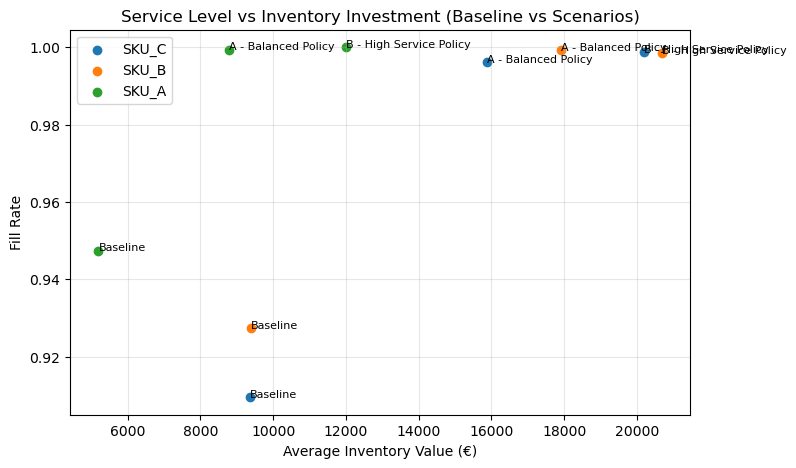

In [13]:
import matplotlib.pyplot as plt

plot_df = tradeoff.copy()

plt.figure(figsize=(8,5))
for sku in plot_df["sku"].unique():
    tmp = plot_df[plot_df["sku"] == sku]
    plt.scatter(tmp["avg_inventory_value"], tmp["fill_rate"], label=sku)
    for _, r in tmp.iterrows():
        plt.text(r["avg_inventory_value"], r["fill_rate"], r["scenario"].split(" (")[0], fontsize=8)

plt.xlabel("Average Inventory Value (€)")
plt.ylabel("Fill Rate")
plt.title("Service Level vs Inventory Investment (Baseline vs Scenarios)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### 5.2 Bar Chart: Lost sales value by scenario

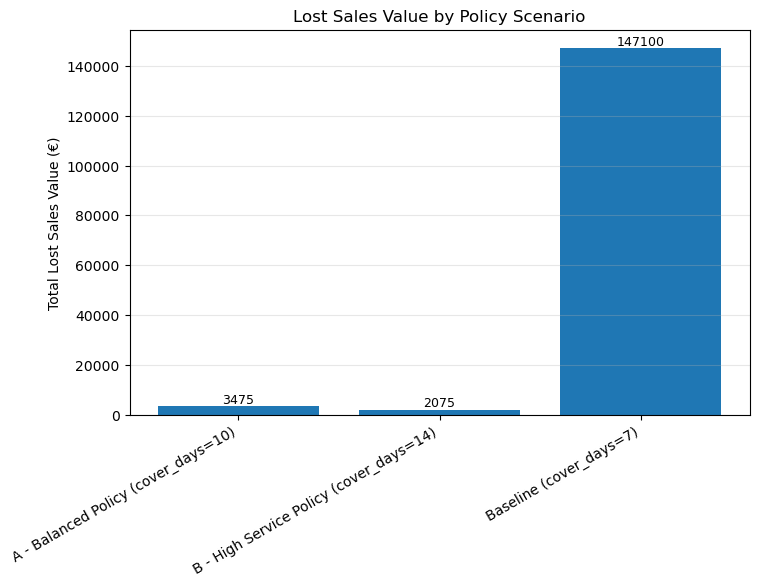

In [14]:
plt.figure(figsize=(8,5))
summary_plot = tradeoff.groupby("scenario")["lost_sales_value"].sum().reset_index()

bars = plt.bar(summary_plot["scenario"], summary_plot["lost_sales_value"])
plt.ylabel("Total Lost Sales Value (€)")
plt.title("Lost Sales Value by Policy Scenario")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", alpha=0.3)

# add value labels
for b in bars:
    plt.text(
        b.get_x() + b.get_width()/2,
        b.get_height(),
        f"{b.get_height():.0f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.show()


This chart compares the total lost sales value (€) under each replenishment policy scenario.
Increasing cover_days reduces stockouts and therefore decreases the monetary impact of lost sales.
Scenario B achieves the lowest lost sales value, but it is expected to require higher inventory investment.

### 5.3 Final Recommendation (Best Policy per SKU)

To select the most appropriate replenishment policy for each SKU, a decision rule applies:

- First, choose the scenario with the highest **fill rate** (service level).
- If multiple scenarios achieve similar fill rate, choose the one with the lower **average inventory value** (lower inventory investment).

This approach reflects a common operational objective:  
maximize service performance while avoiding unnecessary inventory cost.

**Result:** Each SKU may require a different policy depending on its demand behavior, stockout sensitivity, and unit cost.


In [15]:
decision_cols = ["sku", "scenario", "fill_rate", "lost_sales_value", "avg_inventory_value"]
decision = tradeoff[decision_cols].sort_values(["sku", "fill_rate"], ascending=[True, False])
decision


,sku,scenario,fill_rate,lost_sales_value,avg_inventory_value
6,SKU_A,B - High Service Policy (cover_days=14),1.0000,0.0,12013.90
3,SKU_A,A - Balanced Policy (cover_days=10),0.9994,250.0,8787.88
2,SKU_A,Baseline (cover_days=7),0.9474,24150.0,5198.29
4,SKU_B,A - Balanced Policy (cover_days=10),0.9993,600.0,17908.15
7,SKU_B,B - High Service Policy (cover_days=14),0.9985,1200.0,20689.93
1,SKU_B,Baseline (cover_days=7),0.9274,59700.0,9395.55
8,SKU_C,B - High Service Policy (cover_days=14),0.9987,875.0,20185.27
5,SKU_C,A - Balanced Policy (cover_days=10),0.9962,2625.0,15883.90
0,SKU_C,Baseline (cover_days=7),0.9095,63250.0,9352.05


- pick “best scenario per SKU” based on highest fill rate, then lowest inventory value:

In [16]:
best_policy = (
    tradeoff.sort_values(["sku", "fill_rate", "avg_inventory_value"],
                         ascending=[True, False, True])
    .groupby("sku")
    .head(1)
)

best_policy[["sku", "scenario", "fill_rate", "lost_sales_value", "avg_inventory_value"]]


,sku,scenario,fill_rate,lost_sales_value,avg_inventory_value
6,SKU_A,B - High Service Policy (cover_days=14),1.0000,0.0,12013.90
4,SKU_B,A - Balanced Policy (cover_days=10),0.9993,600.0,17908.15
8,SKU_C,B - High Service Policy (cover_days=14),0.9987,875.0,20185.27


## 6. Conclusion

This project evaluated inventory replenishment scenarios by increasing buffer coverage (`cover_days`) and comparing performance against a baseline policy.

Key findings:

- Increasing `cover_days` improves service level (higher fill rate) and reduces lost sales.
- The improvement comes at the cost of higher average inventory value (higher inventory investment).
- The best policy differs by SKU, which supports using SKU-level inventory strategies instead of one aggregated approach.

Overall, the scenario comparison demonstrates the fundamental inventory trade-off:  
**higher service level vs. higher inventory cost**.
